<a href="https://colab.research.google.com/github/SajiniBandara/18031058/blob/main/it18031058_Pytorch_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Import libraries used by thisnotebook.__

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

__Hyperparameters__



In [3]:
ITERATIONS = 10 # Number of iterations
IMAGE_WIDTH = 512 # 512x512 is fine for HD images
IMAGE_HEIGHT = 512
CONTENT_WEIGHT = 1 # Weight of the content loss
STYLE_WEIGHT = 10 # Weight og the style loss
TOTAL_VARIATION_WEIGHT = 10 # Weight of the total variation loss
INPUT_IMAGE = 'noise' # Can be : 'noise', 'content', 'style', or a path to a file.

In [4]:
content_layers = ['relu_9']
style_layers = ['relu_1', 'relu_3', 'relu_5', 'relu_9', 'relu_13']

Names under which the images will be saved.

In [5]:
content_image_path = "content.png"
style_image_path = "style.png"
output_image_path = "result.png"
combined_image_path = "combined.png"

### Images


In [6]:
# Content images
girl = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTtHKQxjY1rDnpvPoHxlWPfRdaKBHnrL0mQ8g&usqp=CAU"
  
# Style images:
styletex = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3Krqg_EJwl4xrWJLHCNFz6ZcydRMkFrsnMQ&usqp=CAU"


# The function wich allow us to download / open an image
def open_image(url):
  if url.startswith("http"):
    return Image.open(BytesIO(requests.get(url).content))
  else:
    return Image.open(url)


In [7]:
content_url = girl
style_url = styletex

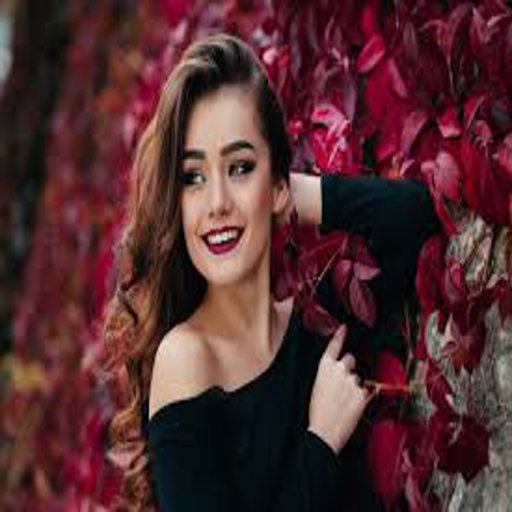

In [8]:
#@title This is the _content_ image
content_image = open_image(content_url)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
content_image.save(content_image_path)
content_image

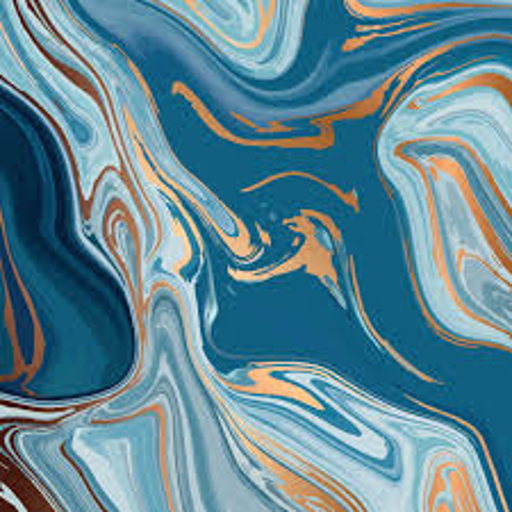

In [9]:
#@title This is the _style_ image
style_image = open_image(style_url)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

# Build the algorithm

In [10]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # We 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable.
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [11]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()

  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

  @staticmethod
  def gram_matrix(input):
    a, b, c, d = input.size()
    # Here:
    # a is the batch size(=1)
    # b is the number of feature maps
    # (c,d) are the dimensions of a feature map

    # We reshape the activation layer into a collection of feature vectors
    features = input.view(a * b, c * d)

    # Compute the gram product
    G = torch.mm(features, features.t())  

    # We 'normalize' the values of the gram matrix
    # by dividing by the norm of gram matrix filled with ones.
    return G.div((a * b * c * d) ** 0.5)

### Total Variation

The last loss is a _smoothing loss_.

In [12]:
def total_variation_loss(x): # Expect a mini batch of dim NxWxH
  image_height = x.shape[1]
  image_width = x.shape[2]
  dx = x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :]
  dy = x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :]
  loss = (dx ** 2 + dy ** 2).sum() ** 0.5
  # Return loss normalized by image and batch size
  return loss / (image_width * image_height * x.shape[0])

In [13]:
# Create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # Reshape the mean and std to make them [C x 1 x 1] so that they can
    # directly broadcast to image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # Normalize img
    return (img - self.mean) / self.std


# Download and build VGG19



In [14]:
# Neural network used.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization mean and standard deviation.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [15]:
def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
  # We make a deep copy of vgg19 in order to not modify the original
  cnn = copy.deepcopy(cnn)
  
  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # This list will contain the losses computed by the network.
  content_losses = []
  style_losses = []

  # We rebuild the model as a nn sequential whose first layer is
  # our normalization layer.
  model = nn.Sequential(normalization)

  # We brows the layer of `cnn` and stack them into `model`.
  i = 0  # Incremented every time we see a conv layer.
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # Check if the layer we just added was in the content layer list.
    # If so, we just stack a Content Loss layer.
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    # Check if the layer we just added was in the style layer list.
    # If so, we just stack a Style Loss layer.
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # Now we trim off the layers after the last content and style losses
  # to keep the model as small as possible.
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

# Running the algorithm

In [16]:
def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)

content_img = image_to_tensor(content_image)
style_img = image_to_tensor(style_image)

In [17]:
# Reconvert a tensor into PIL image
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

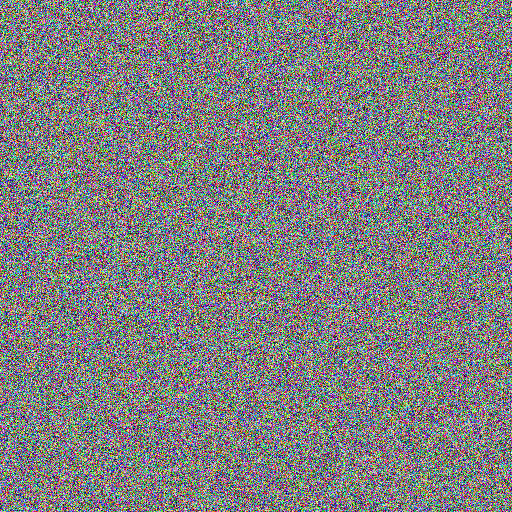

In [18]:
#@title This is the _input_ image
if INPUT_IMAGE == 'noise':
  input_img = torch.randn(content_img.data.size(), device=device)
elif INPUT_IMAGE == 'content':
  input_img = content_img.clone()
elif INPUT_IMAGE == 'style':
  input_img = style_img.clone()
else:
  image = open_image(INPUT_IMAGE).resize((IMAGE_SIZE, IMAGE_SIZE))
  input_img = image_to_tensor(image)
  input_img += torch.randn(content_img.data.size(), device=device)*0.1

# To visualise it better, instead of clipping values, we rescale
# them to fit [-1,1], and convert to an image. This is mostly because
# the visualization given is closer to what the actual values stored
# in the tensor are.
if INPUT_IMAGE == 'noise':
  img = transforms.ToPILImage()(input_img[0].cpu())
else:
  img = tensor_to_image(input_img[0])
img

In [19]:
def get_input_optimizer(input_img):
  # This line tell LBFGS what parameters we should optimize
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  #optimizer = optim.Adam([input_img.requires_grad_()])
  return optimizer

In [20]:
def show_evolution(tensor, history=[], title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = tensor_to_image(image)
    # Display a big figure
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    # Image
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    # Losses
    ax = plt.subplot(122)
    plt.yscale('log')
    plt.title('Losses')
    import numpy as np
    history = np.array(history).T
    plt.plot(history[0], label='Style')
    plt.plot(history[1], label='Content')
    plt.plot(history[2], label='Variation')
    plt.plot(history[3], label='Sum')
    plt.legend(loc="upper right")
    # Finaly show the graph
    plt.show()
    # Display a textual message
    print('Style Loss : {:4f} Content Loss: {:4f} Variation Loss: {:4f} Sum: {:4f}'.format(
        history[0][-1], history[1][-1], history[2][-1], history[3][-1]))

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, cei

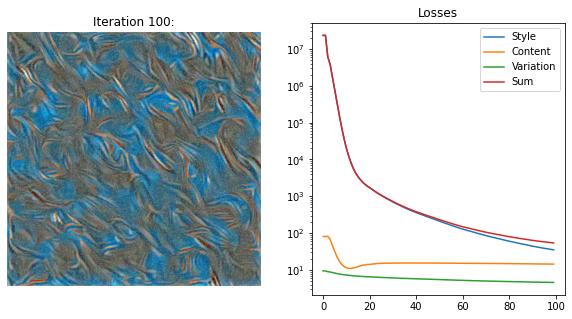

Style Loss : 35.128769 Content Loss: 14.439602 Variation Loss: 4.590606 Sum: 54.158978


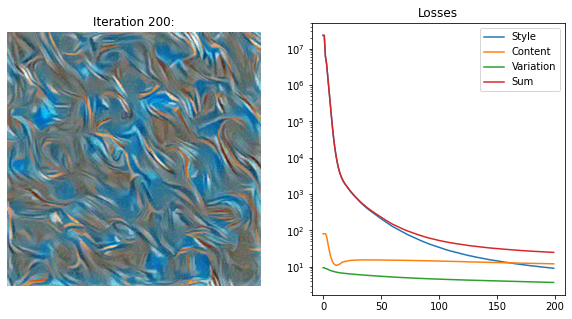

Style Loss : 9.119936 Content Loss: 12.091020 Variation Loss: 3.711324 Sum: 24.922279


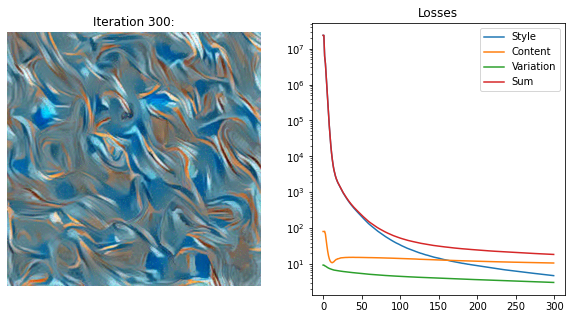

Style Loss : 4.790058 Content Loss: 10.759604 Variation Loss: 3.095595 Sum: 18.645256


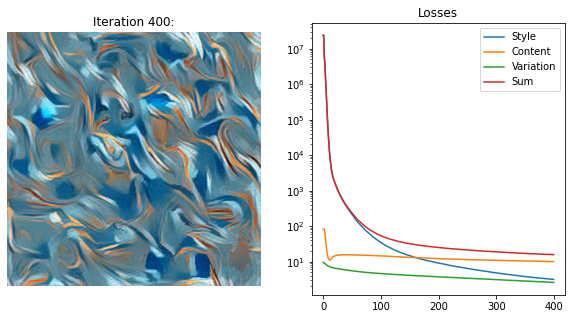

Style Loss : 3.128995 Content Loss: 9.923941 Variation Loss: 2.571836 Sum: 15.624772


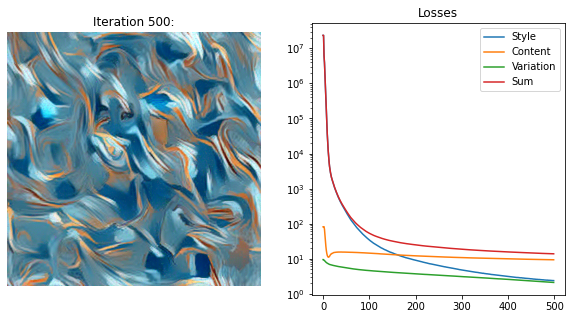

Style Loss : 2.370716 Content Loss: 9.311477 Variation Loss: 2.100531 Sum: 13.782723


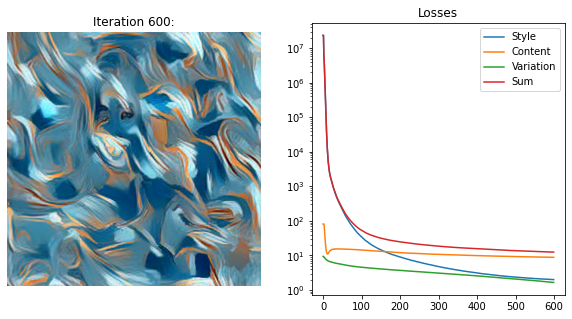

Style Loss : 2.005682 Content Loss: 8.851107 Variation Loss: 1.657883 Sum: 12.514671


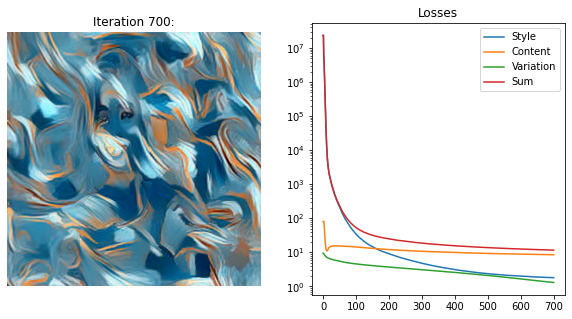

Style Loss : 1.801869 Content Loss: 8.506250 Variation Loss: 1.307098 Sum: 11.615217


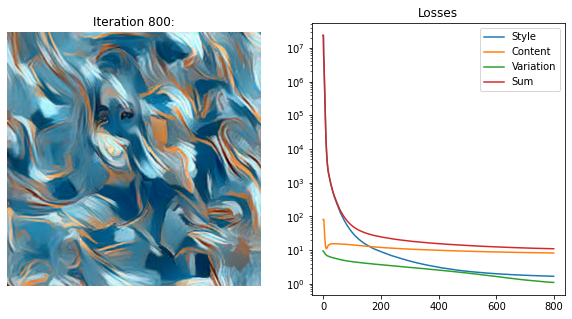

Style Loss : 1.677420 Content Loss: 8.230919 Variation Loss: 1.103727 Sum: 11.012066


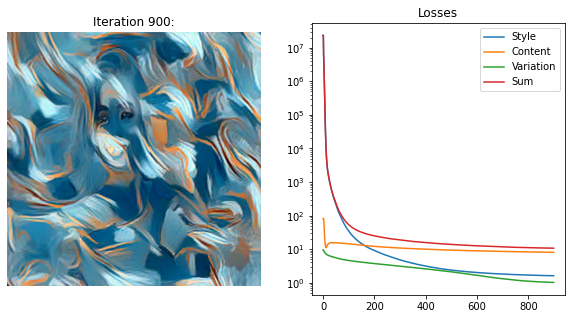

Style Loss : 1.603689 Content Loss: 8.013361 Variation Loss: 1.012384 Sum: 10.629434


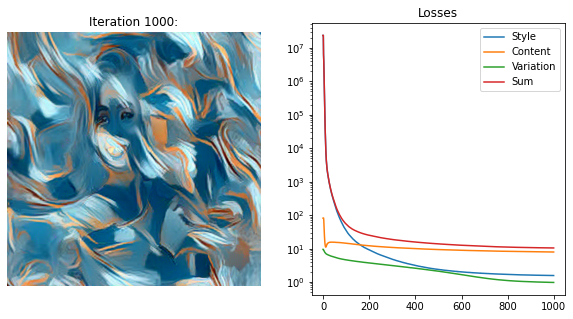

Style Loss : 1.558172 Content Loss: 7.857669 Variation Loss: 0.967352 Sum: 10.383194


In [21]:
print('Building the style transfer model..')
model, style_losses, content_losses = get_model_and_losses(style_img, content_img)
optimizer = get_input_optimizer(input_img)

print('Optimizing..')
iterations = 0
history=[]
while iterations <= ITERATIONS * 100:
  # Compute the loss and backpropagate to the input_image.
  # (The LBFGS optimizer only accept work through closures.)
  def closure():
      global history
      global iterations
      
      optimizer.zero_grad()
      
      # Compute the total variation loss
      variation_score = total_variation_loss(input_img) * TOTAL_VARIATION_WEIGHT
      # Compute the features through the model
      model(input_img)
      # Compute style and content losses
      style_score = sum(sl.loss for sl in style_losses)
      style_score *= STYLE_WEIGHT / len(style_losses)
      content_score = sum(cl.loss for cl in content_losses)
      content_score *= CONTENT_WEIGHT / len(content_losses)
      # Our global loss is the sum of the 3 values
      loss = style_score + content_score + variation_score
      # Save the value of loss in order to draw them as a graph
      history += [[style_score.item(), content_score.item(), variation_score.item(), loss.item()]]

      # If the iteration is a multiple of 100, display some informations
      iterations += 1
      if iterations % 100 == 0:
          show_evolution(input_img.data.clone().detach().clamp(0, 1), history, title="Iteration %d:" % iterations)
      
      # Backpropagate gradients and leave the optimizer do his job.
      loss.backward()
      return loss

  optimizer.step(closure)


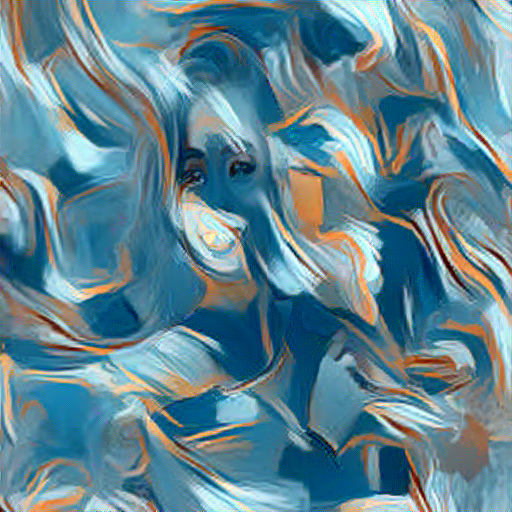

In [22]:
#@title Our beautiful result
img = tensor_to_image(input_img)
img.save(output_image_path)
img

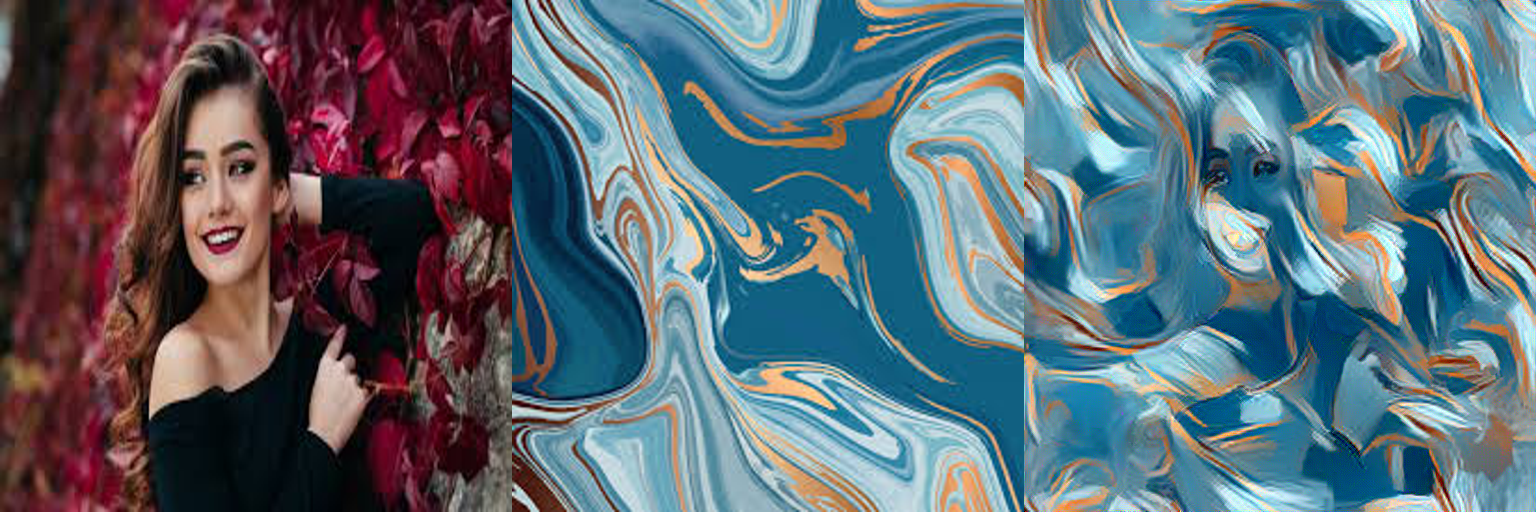

In [23]:
#@title Visualise combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [content_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined